# 🎛️ FSBB 200W 数字控制回路设计 (Digital Control Loop Design)

**项目**: BIDIR-4SW-BUCKBOOST
**作者**: wxw
**日期**: 2025-11-29
目标: 计算 ADC 采样系数 与 PID 控制器参数 ($K_p, K_i$)
方法: 频域分析法 (Frequency Domain Analysis)

## 1. 采样电路归一化系数 (ADC Scaling)

软件读取到的 ADC 只是 0-4095 的数字。我们需要把它转换为真实的物理量（或者归一化量）。
TI DSP 开发中，通常有两种流派：
1.  **物理值流派**: 都在 ISR 里算 `float` (Volts)，直观，但慢。
2.  **标幺值 (PU) 流派**: 把所有电压映射到 0.0 - 1.0。

鉴于 F28335 有 FPU，我们采用 **物理值流派 (Engineering Value)**，方便调试。

### 硬件参数
* **ADC 量程**: $V_{adc\_ref} = 3.0V$ (注意 F28335 内部参考通常是 3.0V，外部可能有缓冲)
* **ADC 分辨率**: 12-bit ($2^{12} = 4096$)
* **分压电阻**: $R_{up}=30k, R_{low}=3.3k$ (根据上一份计算书)
* **电流采样**: $R_{sense}=3m\Omega, Gain=15$

In [ ]:
# --- 1. ADC Scaling Calculations ---

# Hardware Specs
ADC_BITS = 12
ADC_REF  = 3.0    # V (Check your F28335 board schematic!)
ADC_MAX  = 2**ADC_BITS

# Voltage Divider (Vin & Vout)
R_up  = 30.0e3    # 30k
R_low = 3.3e3     # 3.3k
K_div = R_low / (R_up + R_low)

# Current Sense
R_sense = 0.003   # 3 mOhm
Op_Gain = 15.0    # Op-amp Gain

# --- Software Coefficients ---
# Formula: V_physical = ADC_Count * K_adc_to_phys

# 1. Voltage Coefficient (ADC Count -> Volts)
# V_pin = V_physical * K_div
# ADC_Count = (V_pin / ADC_REF) * ADC_MAX
# -> V_physical = ADC_Count * (ADC_REF / ADC_MAX) / K_div
K_V_scale = (ADC_REF / ADC_MAX) / K_div

# 2. Current Coefficient (ADC Count -> Amps)
# V_pin = I_physical * R_sense * Op_Gain + V_offset(1.5V)
# We handle offset in software subtraction
# Slope: ADC_Count_Delta = (I * R * G / REF) * MAX
K_I_scale = (ADC_REF / ADC_MAX) / (R_sense * Op_Gain)

print(f"✅ ADC Scaling Factors (Write these to DSP Code):")
print(f"#define K_VOLT  {K_V_scale:.6f}f // Volts per count")
print(f"#define K_AMP   {K_I_scale:.6f}f // Amps per count")

# Test
print(f"\n[Test] Reading 2048 counts:")
print(f"  Voltage = {2048 * K_V_scale:.2f} V")

## 2. 被控对象建模 (Plant Modeling)

在设计 PID 之前，我们需要知道这个电路的“脾气”（传递函数）。
四开关 Buck-Boost 的模型很复杂，但在 **Buck 模式** 下，它就是一个经典的二阶 LC 系统。

我们以 Buck 模式为例进行设计。如果 Buck 模式稳了，Boost 模式通常只需要降低带宽即可（因为 Boost 有右半平面零点 RHPZ 带来的相位滞后，不能调太快）。

### Buck 模式传递函数 ($G_{vd}$)
占空比到输出电压的小信号模型：
$$G_{vd}(s) = \frac{\hat{v}_{out}}{\hat{d}} = V_{in} \cdot \frac{1}{1 + s\frac{L}{R} + s^2 LC}$$

*注：这是一个简化模型，忽略了 ESR 零点，适合低频设计。*

In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# --- 2. Plant Definition ---

# Parameters from previous calculation
Vin  = 30.0      # V (Max input voltage is worst case for gain)
Vout = 24.0      # V
L    = 22e-6     # H
C    = 940e-6    # F (2x 470uF)
R_load = Vout**2 / 200.0 # Full load resistance (Worst for damping)

# Transfer Function: Gvd(s)
# Numerator: [Vin]
# Denominator: [L*C, L/R, 1]
num = [Vin]
den = [L*C, L/R_load, 1]

G_plant = ct.tf(num, den)

print("Plant Transfer Function (Buck Mode):")
print(G_plant)

# Analyze Resonance Frequency
w0 = 1 / np.sqrt(L*C)
f0 = w0 / (2*np.pi)
print(f"\nLC Resonance Frequency: {f0:.2f} Hz")

Plant Transfer Function (Buck Mode):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

                30
  -------------------------------
  2.068e-08 s^2 + 7.639e-06 s + 1

LC Resonance Frequency: 1106.74 Hz


## 3. PID 控制器设计 (Loop Shaping)

### 设计目标
我们使用电压单环控制。
1.  **截止频率 (Bandwidth, $f_c$)**: 设定为 **800 Hz**。
    * *理由*: LC 谐振在 1.1kHz 附近。为了稳定性，我们将带宽设在谐振频率以下，避免相位剧烈翻转带来的振荡。
2.  **相位裕度 (Phase Margin, PM)**: **> 45度** (最好 60度)。

### 控制器形式 (PI)
$$G_{c}(s) = K_p + \frac{K_i}{s}$$

/Users/wangxuwen/code/bidir-4sw-buckboost/venv/lib/python3.13/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/var/folders/1s/yzp1yg7j1qs98v37vtft030m0000gn/T/ipykernel_2075/412421536.py:37: FutureWarning: keyword 'margins' is deprecated; use 'display_margins'
  ct.bode_plot(L_open, dB=True, margins=True)



Calculated PID Parameters:
Kp = 0.01597
Ki = 55.51907


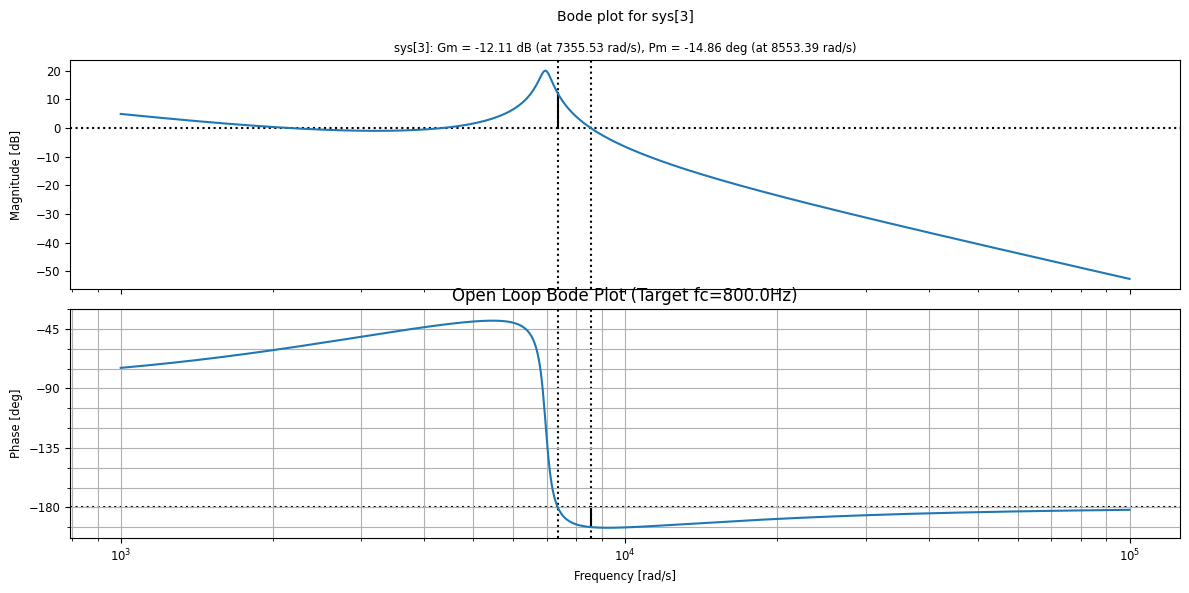

Phase Margin: -14.86 degrees at 1361.31 Hz
❌ Stability Check FAILED - Reduce Bandwidth


In [2]:
# --- 3. Controller Tuning ---

# Target Bandwidth
fc_target = 800.0 # Hz
wc_target = 2 * np.pi * fc_target

# Calculate PI Parameters manually to match target magnitude at fc
# At crossover frequency, |L(jw)| = 1 -> |C(jw)| * |P(jw)| = 1
# -> |C(jw)| = 1 / |P(jw)|

# Get Plant Magnitude/Phase at target freq
mag_plant, phase_plant, omega = ct.bode(G_plant, [wc_target], plot=False)
mag_plant_val = mag_plant[0]

# Desired Controller Gain at fc
K_total_needed = 1.0 / mag_plant_val

# Strategy: Place the PI Zero (w_z = Ki/Kp) at 0.5 * f0 (cancel some phase drop)
w_z = 0.5 * w0 # Place zero below resonance
Kp = K_total_needed # Approximation
Ki = Kp * w_z

print(f"\nCalculated PID Parameters:")
print(f"Kp = {Kp:.5f}")
print(f"Ki = {Ki:.5f}")

# Define Controller Transfer Function
ctrl_num = [Kp, Ki]
ctrl_den = [1, 0] # s
C_pid = ct.tf(ctrl_num, ctrl_den)

# Open Loop Transfer Function L(s) = C(s) * P(s)
L_open = C_pid * G_plant

# --- 4. Verification (Bode Plot) ---
plt.figure(figsize=(12, 6))
ct.bode_plot(L_open, dB=True, margins=True)
plt.title(f"Open Loop Bode Plot (Target fc={fc_target}Hz)")
plt.grid(True, which='both')
plt.show()

# Get Margins
gm, pm, wg, wp = ct.margin(L_open)
print(f"Phase Margin: {pm:.2f} degrees at {wp/(2*np.pi):.2f} Hz")
if pm > 45:
    print("✅ Stability Check PASSED")
else:
    print("❌ Stability Check FAILED - Reduce Bandwidth")

## 4. 数字离散化 (Discretization for C Code)

我们在 DSP 中运行的是离散代码，不是连续的 $s$ 域公式。
我们需要将 PI 控制器转换为差分方程：
$$u[k] = u[k-1] + b_0 \cdot e[k] + b_1 \cdot e[k-1]$$

使用 **Tustin 变换 (双线性变换)** 进行离散化。
采样周期 $T_s = 1 / f_{sw} = 10 \mu s$ (假设 100kHz 环路，如果是 20kHz 需修改)。

In [3]:
# --- 5. Digital Implementation Code Gen ---

Fs = 20000.0 # Sampling Frequency (Matches PWM Freq 20kHz)
Ts = 1.0 / Fs

# Discrete Controller Coefficients (Tustin)
# C(z) = (b0 + b1*z^-1) / (1 - z^-1)
# b0 = Kp + Ki*Ts/2
# b1 = -Kp + Ki*Ts/2

b0 = Kp + (Ki * Ts / 2.0)
b1 = -Kp + (Ki * Ts / 2.0)

print("="*40)
print("🚀 C CODE COPY-PASTE BLOCK")
print("="*40)
print(f"// PID Constants for Fs = {Fs/1000:.0f} kHz")
print(f"float pid_b0 = {b0:.6f}f;")
print(f"float pid_b1 = {b1:.6f}f;")
print(f"float u_prev = 0.0f;")
print(f"float e_prev = 0.0f;")
print("")
print("// PID Calculation Function (Put in ISR)")
print("float error = V_ref - V_out_meas;")
print("float u_out = u_prev + pid_b0 * error + pid_b1 * e_prev;")
print("")
print("// Saturation (Anti-windup)")
print("if(u_out > 1.0f) u_out = 1.0f;")
print("if(u_out < 0.0f) u_out = 0.0f;")
print("")
print("// Update history")
print("u_prev = u_out;")
print("e_prev = error;")
print("="*40)

🚀 C CODE COPY-PASTE BLOCK
// PID Constants for Fs = 20 kHz
float pid_b0 = 0.017356f;
float pid_b1 = -0.014580f;
float u_prev = 0.0f;
float e_prev = 0.0f;

// PID Calculation Function (Put in ISR)
float error = V_ref - V_out_meas;
float u_out = u_prev + pid_b0 * error + pid_b1 * e_prev;

// Saturation (Anti-windup)
if(u_out > 1.0f) u_out = 1.0f;
if(u_out < 0.0f) u_out = 0.0f;

// Update history
u_prev = u_out;
e_prev = error;
